In [1]:
# change root path one level up
import os

os.chdir("..")


In [26]:
# lightgbm and optuna
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
import pytz
import time
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

CAT_FEATURES = ["userID"]
NUM_FEATURES = [
    "connectionTime_hour_x",
    "connectionTime_hour_y",
    "connectionTime_month_x",
    "connectionTime_month_y",
    "connectionTime_weekday_x",
    "connectionTime_weekday_y",
]


In [17]:
sessions = pd.read_csv("./data/caltech_test_data.csv", index_col=[0, 1])
# drop idle_time column
sessions = sessions.drop(
    columns=["idle_time", "Requested_parking_time", "kWhRequested", "kWhDelivered"]
)
for cols in CAT_FEATURES:
    sessions[cols] = sessions[cols].astype("category")
sessions["parking_time_log"] = np.log(sessions["parking_time"])
sessions = sessions[NUM_FEATURES + CAT_FEATURES + ["parking_time_log", "parking_time"]]
sessions


connectionTime_hour_x  \
connection_time_copy _id                                               
2018-04-30           5bc915caf9af8b0dad3c0660          -5.000000e-01   
2018-05-07           5bc917d0f9af8b0dc677b8bb          -2.588190e-01   
2018-05-11           5bc9190ff9af8b0dc677b9c1          -5.000000e-01   
2018-05-14           5bc919c3f9af8b0dc677ba32           8.770390e-14   
                     5bc919c3f9af8b0dc677ba62          -2.588190e-01   
...                                                              ...   
2019-12-30           5e1fbc9ff9af8b5391bcd6fc          -7.071068e-01   
                     5e1fbc9ff9af8b5391bcd700          -1.000000e+00   
2019-12-31           5e210e1ff9af8b57bb4f54fa          -5.000000e-01   
                     5e210e1ff9af8b57bb4f54fd          -9.659258e-01   
                     5e210e1ff9af8b57bb4f5500           1.133298e-14   

                                               connectionTime_hour_y  \
connection_time_copy _id                                               
2018-04-30           5bc915caf9af8b0dad3c0660           8.660254e-01   
2018-05-07           5bc917d0f9af8b0dc677b8bb           9.659258e-01   
2018-05-11           5bc9190ff9af8b0dc677b9c1           8.660254e-01   
2018-05-14           5bc919c3f9af8b0dc677ba32           1.000000e+00   
                     5bc919c3f9af8b0dc677ba62          -9.659258e-01   
...                                                              ...   
2019-12-30           5e1fbc9ff9af8b5391bcd6fc           7.071068e-01   
                     5e1fbc9ff9af8b5391bcd700          -9.512791e-14   
2019-12-31           5e210e1ff9af8b57bb4f54fa           8.660254e-01   
                     5e210e1ff9af8b57bb4f54fd           2.588190e-01   
                     5e210e1ff9af8b57bb4f5500          -1.000000e+00   

                                               connectionTime_month_x  \
connection_time_copy _id                                                
2018-04-30           5bc915caf9af8b0dad3c0660                0.892254   
2018-05-07           5bc917d0f9af8b0dc677b8bb                0.565554   
2018-05-11           5bc9190ff9af8b0dc677b9c1               -0.232105   
2018-05-14           5bc919c3f9af8b0dc677ba32               -0.742684   
                     5bc919c3f9af8b0dc677ba62               -0.802694   
...                                                               ...   
2019-12-30           5e1fbc9ff9af8b5391bcd6fc                0.968119   
                     5e1fbc9ff9af8b5391bcd700                0.974267   
2019-12-31           5e210e1ff9af8b57bb4f54fa                0.998482   
                     5e210e1ff9af8b57bb4f54fd                0.999571   
                     5e210e1ff9af8b57bb4f5500                0.999519   

                                               connectionTime_month_y  \
connection_time_copy _id                                                
2018-04-30           5bc915caf9af8b0dad3c0660               -0.451533   
2018-05-07           5bc917d0f9af8b0dc677b8bb                0.824711   
2018-05-11           5bc9190ff9af8b0dc677b9c1                0.972691   
2018-05-14           5bc919c3f9af8b0dc677ba32                0.669642   
                     5bc919c3f9af8b0dc677ba62                0.596391   
...                                                               ...   
2019-12-30           5e1fbc9ff9af8b5391bcd6fc               -0.250491   
                     5e1fbc9ff9af8b5391bcd700               -0.225399   
2019-12-31           5e210e1ff9af8b57bb4f54fa               -0.055088   
                     5e210e1ff9af8b57bb4f54fd               -0.029276   
                     5e210e1ff9af8b57bb4f5500                0.030998   

                                               connectionTime_weekday_x  \
connection_time_copy _id                                                  
2018-04-30           5bc915caf9af8b0dad3c0660              9.555728e-01   
2018-05-07           5bc917d0f9af8b0dc677b8bb   

In [18]:
# find dates 30, 60, 120, 240, 360, 480, 600 days before 2020-12-01 and make a list of them
dates = []
for i in [30, 60, 120, 240, 360, 480]:
    dates.append((datetime(2019, 12, 1) - timedelta(days=i)).strftime("%Y-%m-%d"))
dates


['2019-11-01',
 '2019-10-02',
 '2019-08-03',
 '2019-04-05',
 '2018-12-06',
 '2018-08-08']

In [19]:
# make 6 partitions for training starting with dates[i] and ending with datetime(2020, 12, 1)
train_sessions = []
for i in range(len(dates)):
    train_sessions.append(sessions.loc[dates[i] : "2019-12-01"])
    # print number of sessions in each partition
    print(train_sessions[i].shape)


(196, 9)
(403, 9)
(910, 9)
(2127, 9)
(3627, 9)
(4779, 9)


In [20]:
# keep last 30 days for validation
val_0 = sessions.loc[(slice("2019-11-15", "2019-12-01"), slice(None)), :]
val_1 = sessions.loc[(slice("2019-11-01", "2019-12-01"), slice(None)), :]


In [21]:
# testing data is collected from Dec. 1, 2018 to Jan. 1, 2019
test = sessions.loc[(slice("2019-12-01", "2020-01-01"), slice(None)), :]
# print test size
print(test.shape)


(157, 9)


In [22]:
# train lightgbm model to predict the log1p of parking_time
def train_lgb(train, params, num_rounds=200, early_stopping_rounds=10):
    # keep 20% of training data from the end for validation
    val = train.iloc[-int(0.2 * len(train)) :]
    # create lgb datasets
    train_data = lgb.Dataset(
        train.drop(columns=["parking_time", "parking_time_log"]),
        label=train["parking_time_log"],
        categorical_feature=CAT_FEATURES,
    )
    val_data = lgb.Dataset(
        val.drop(columns=["parking_time", "parking_time_log"]),
        label=val["parking_time_log"],
        categorical_feature=CAT_FEATURES,
    )
    # train model
    model = lgb.train(params, train_data, num_rounds, verbose_eval=False)
    return model


# optimize hyperparameters of lightgbm model using optuna
def objective(trial, train_opt, val_opt):
    # define hyperparameters
    params = {
        "objective": "regression_l1",
        "metric": "mae",
        "verbose": -1,
        "seed": 42,
        "num_leaves": trial.suggest_int("num_leaves", 2, 200),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "min_data": trial.suggest_int("min_data", 1, 100),
        # regularization
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-3, 1e3),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 1e3),
    }
    # train model
    model = train_lgb(
        train_opt, val_opt, params, num_rounds=200, early_stopping_rounds=10
    )
    # predict on validation set
    y_pred = model.predict(val_0.drop(columns=["parking_time", "parking_time_log"]))
    # calculate mae
    mae = np.mean(np.abs(val_0["parking_time_log"] - y_pred))
    return mae


def run_hp(train, val, n_trials=100):
    train_opt = train.copy()
    val_opt = val.copy()
    # time the training
    start = time.time()
    # Wrap the objective inside a lambda and call objective inside it
    func = lambda trial: objective(trial, train_opt, val_opt)
    # optimize hyperparameters
    study = optuna.create_study(direction="minimize")
    study.optimize(func, n_trials=n_trials)
    # print best hyperparameters
    print("Best hyperparameters: ", study.best_params)
    # train model with best hyperparameters
    model = train_lgb(
        train, val, study.best_params, num_rounds=200, early_stopping_rounds=10
    )
    log_time = time.time() - start
    # print time taken to train
    print("Time taken to train: ", time.time() - start)
    del train_opt, val_opt
    return model, log_time


In [23]:
# train model with best hyperparameters
model_0, t_0 = run_hp(train_sessions[0], val_0, n_trials=100)
model_1, t_1 = run_hp(train_sessions[1], val_1, n_trials=100)
model_2, t_2 = run_hp(train_sessions[2], val_1, n_trials=100)
model_3, t_3 = run_hp(train_sessions[3], val_1, n_trials=100)
model_4, t_4 = run_hp(train_sessions[4], val_1, n_trials=100)
model_5, t_5 = run_hp(train_sessions[5], val_1, n_trials=100)


[I 2023-05-15 17:57:31,890] A new study created in memory with name: no-name-7a3bd4e7-a94b-4d83-aa8b-dbfc61fc2717
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-15 17:57:31,933] Trial 0 finished with value: 0.6022618125085709 and parameters: {'num_leaves': 191, 'max_depth': 3, 'learning_rate': 0.003870126158169501, 'min_data': 84, 'lambda_l1': 82.06176153652952, 'lambda_l2': 0.03274568570380475}. Best is trial 0 with value: 0.6022618125085709.
/Users/evge

Best hyperparameters:  {'num_leaves': 76, 'max_depth': 5, 'learning_rate': 0.09980472589169238, 'min_data': 1, 'lambda_l1': 0.0068105765180323284, 'lambda_l2': 6.038769640078059}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 196, number of used features: 7
[LightGBM] [Info] Start training from score 1.750690
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2023-05-15 17:57:44,945] Trial 1 finished with value: 0.43936694260897335 and parameters: {'num_leaves': 134, 'max_depth': 4, 'learning_rate': 0.009398308699986792, 'min_data': 3, 'lambda_l1': 0.09212275717885617, 'lambda_l2': 0.061471602384242464}. Best is trial 1 with value: 0.43936694260897335.
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-15 17:57:45,034] Trial 2 finished with value: 0.41889628403772505 and parameters: {'num_leaves': 191, 'max_dep

Best hyperparameters:  {'num_leaves': 180, 'max_depth': 5, 'learning_rate': 0.09303481078214718, 'min_data': 1, 'lambda_l1': 0.013582518411505446, 'lambda_l2': 0.004560821512097814}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 7
[LightGBM] [Info] Start training from score 1.839300
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[I 2023-05-15 17:58:01,335] A new study created in memory with name: no-name-97920528-20bd-43bb-8cbc-8cf479a7fdd9


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-15 17:58:01,485] Trial 0 finished with value: 0.38827012763619234 and parameters: {'num_leaves': 107, 'max_depth': 5, 'learning_rate': 0.09423840701591811, 'min_data': 30, 'lambda_l1': 0.0010091825642571063, 'lambda_l2': 884.8241028318182}. Best is trial 0 with value: 0.38827012763619234.
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categori

Best hyperparameters:  {'num_leaves': 111, 'max_depth': 5, 'learning_rate': 0.09876167862488866, 'min_data': 11, 'lambda_l1': 0.0016929357626007965, 'lambda_l2': 0.004042887967324095}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1549
[LightGBM] [Info] Number of data points in the train set: 910, number of used features: 7
[LightGBM] [Info] Start training from score 1.789907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2023-05-15 17:58:20,373] Trial 0 finished with value: 0.5079891773590375 and parameters: {'num_leaves': 87, 'max_depth': 2, 'learning_rate': 0.006493340105985189, 'min_data': 5, 'lambda_l1': 0.041132019198328734, 'lambda_l2': 7.7367905212629235}. Best is trial 0 with value: 0.5079891773590375.
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-15 17:58:20,561] Trial 1 finished with value: 0.5440138871921161 and parameters: {'num_leaves': 200, 'max_depth': 

Best hyperparameters:  {'num_leaves': 70, 'max_depth': 5, 'learning_rate': 0.07722858113048597, 'min_data': 1, 'lambda_l1': 0.0020222836741492787, 'lambda_l2': 552.2752834031834}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1559
[LightGBM] [Info] Number of data points in the train set: 2127, number of used features: 7
[LightGBM] [Info] Start training from score 1.774527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

[I 2023-05-15 17:58:46,373] A new study created in memory with name: no-name-741949ca-f890-4366-ba18-361255ce8136


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-15 17:58:46,690] Trial 0 finished with value: 0.5239937509512551 and parameters: {'num_leaves': 128, 'max_depth': 5, 'learning_rate': 0.0037183412052300235, 'min_data': 81, 'lambda_l1': 34.02377798375883, 'lambda_l2': 1.6766198603248352}. Best is trial 0 with value: 0.5239937509512551.
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical

Best hyperparameters:  {'num_leaves': 183, 'max_depth': 5, 'learning_rate': 0.08759247401026624, 'min_data': 3, 'lambda_l1': 0.4983542343444662, 'lambda_l2': 0.11050154404726617}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1564
[LightGBM] [Info] Number of data points in the train set: 3627, number of used features: 7
[LightGBM] [Info] Start training from score 1.765361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2023-05-15 17:59:12,383] A new study created in memory with name: no-name-b965ebbd-0e8a-4b93-9524-b05fb358fb5a


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-15 17:59:12,682] Trial 0 finished with value: 0.49548351730721946 and parameters: {'num_leaves': 136, 'max_depth': 4, 'learning_rate': 0.0047472296467395, 'min_data': 75, 'lambda_l1': 0.0013015639562261115, 'lambda_l2': 0.005838270598947514}. Best is trial 0 with value: 0.49548351730721946.
/Users/evgenygenov/miniforge3/envs/caltech/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using catego

Best hyperparameters:  {'num_leaves': 32, 'max_depth': 5, 'learning_rate': 0.09974556107752687, 'min_data': 1, 'lambda_l1': 3.7419940703904824, 'lambda_l2': 0.0013581796398322455}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 4779, number of used features: 7
[LightGBM] [Info] Start training from score 1.772112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [24]:
# print times
print("Time taken to train model 0: ", t_0)
print("Time taken to train model 1: ", t_1)
print("Time taken to train model 2: ", t_2)
print("Time taken to train model 3: ", t_3)
print("Time taken to train model 4: ", t_4)
print("Time taken to train model 5: ", t_5)


Time taken to train model 0:  12.883547067642212
Time taken to train model 1:  16.562509059906006
Time taken to train model 2:  18.954604148864746
Time taken to train model 3:  26.078346014022827
Time taken to train model 4:  26.007233142852783
Time taken to train model 5:  30.83559775352478


In [11]:
# test model on test data
def test_lgb(model, test):
    # time the testing
    start = time.time()
    # test model
    y_pred = model.predict(test.drop(columns=["parking_time", "parking_time_log"]))
    # expm1 to get original values
    y_pred = np.exp(y_pred)
    y_true = test["parking_time"]
    # print time taken to test
    print("Time taken to test: ", time.time() - start)
    return y_pred, y_true


def test_lgb_timed(model, test, n_iters=20):
    runtime_list = []
    for i in range(n_iters):
        # time the testing
        start = time.time()
        # test model
        y_pred = model.predict(test.drop(columns=["parking_time", "parking_time_log"]))
        # expm1 to get original values
        y_pred = np.exp(y_pred)
        y_true = test["parking_time"]
        # print time taken to test
        runtime_list.append(time.time() - start)
    print(np.mean(runtime_list))
    return y_pred, y_true


# test model for each time interval
y_pred_0, y_true_0 = test_lgb(model_0, test)
y_pred_1, y_true_1 = test_lgb(model_1, test)
y_pred_2, y_true_2 = test_lgb(model_2, test)
y_pred_3, y_true_3 = test_lgb(model_3, test)
y_pred_4, y_true_4 = test_lgb(model_4, test)
y_pred_5, y_true_5 = test_lgb(model_5, test)


Time taken to test:  0.017382144927978516
Time taken to test:  0.004202842712402344
Time taken to test:  0.0024619102478027344
Time taken to test:  0.0022728443145751953
Time taken to test:  0.004691123962402344
Time taken to test:  0.014428138732910156


In [12]:
y_pred_0, y_true_0 = test_lgb_timed(model_0, test)
y_pred_1, y_true_1 = test_lgb_timed(model_1, test)
y_pred_2, y_true_2 = test_lgb_timed(model_2, test)
y_pred_3, y_true_3 = test_lgb_timed(model_3, test)
y_pred_4, y_true_4 = test_lgb_timed(model_4, test)
y_pred_5, y_true_5 = test_lgb_timed(model_5, test)


0.002390110492706299
0.0018999934196472167
0.0017615556716918945
0.0018615365028381349
0.0018639922142028808
0.0019173622131347656


In [13]:
# evaluate smape of lightgbm model
def smape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + y_pred))) * 100


def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


# evaluate smape for each time interval

print("smape for time interval 0: ", smape(y_true_0.values, y_pred_0))
print("smape for time interval 1: ", smape(y_true_1.values, y_pred_1))
print("smape for time interval 2: ", smape(y_true_2.values, y_pred_2))
print("smape for time interval 3: ", smape(y_true_3.values, y_pred_3))
print("smape for time interval 4: ", smape(y_true_4.values, y_pred_4))
print("smape for time interval 5: ", smape(y_true_5.values, y_pred_5))


smape for time interval 0:  17.34751882617235
smape for time interval 1:  14.925262745613757
smape for time interval 2:  12.860283125499988
smape for time interval 3:  13.100448975725474
smape for time interval 4:  12.318669763036276
smape for time interval 5:  12.502400337750522


In [25]:
# make a table with the results
results = pd.DataFrame(
    {
        "time_interval": [30, 60, 120, 240, 360, 480],
        "smape": [
            smape(y_true_0.values, y_pred_0),
            smape(y_true_1.values, y_pred_1),
            smape(y_true_2.values, y_pred_2),
            smape(y_true_3.values, y_pred_3),
            smape(y_true_4.values, y_pred_4),
            smape(y_true_5.values, y_pred_5),
        ],
    }
)
# add a column for mae
results["mae"] = [
    mae(y_true_0.values, y_pred_0),
    mae(y_true_1.values, y_pred_1),
    mae(y_true_2.values, y_pred_2),
    mae(y_true_3.values, y_pred_3),
    mae(y_true_4.values, y_pred_4),
    mae(y_true_5.values, y_pred_5),
]
results


,time_interval,smape,mae
0,30,17.347519,2.506168
1,60,14.925263,2.172904
2,120,12.860283,1.881937
3,240,13.100449,1.918964
4,360,12.318670,1.798506
5,480,12.502400,1.856693


In [33]:
save_error_dist(y_true_0, y_pred_0, "lgb_30_duration")
save_error_dist(y_true_1, y_pred_1, "lgb_60_duration")
save_error_dist(y_true_2, y_pred_2, "lgb_120_duration")
save_error_dist(y_true_3, y_pred_3, "lgb_240_duration")
save_error_dist(y_true_4, y_pred_4, "lgb_360_duration")
save_error_dist(y_true_5, y_pred_5, "lgb_480_duration")

In [32]:
# save distribution of errors
def save_error_dist(y_true, y_pred, name):
    error = y_pred - y_true
    # save as a picle file
    with open('./results/'+name+'.pkl', "wb") as f:
        pickle.dump(error, f)

In [15]:
results.to_csv("results/lightgbm_duration.csv", index=False)

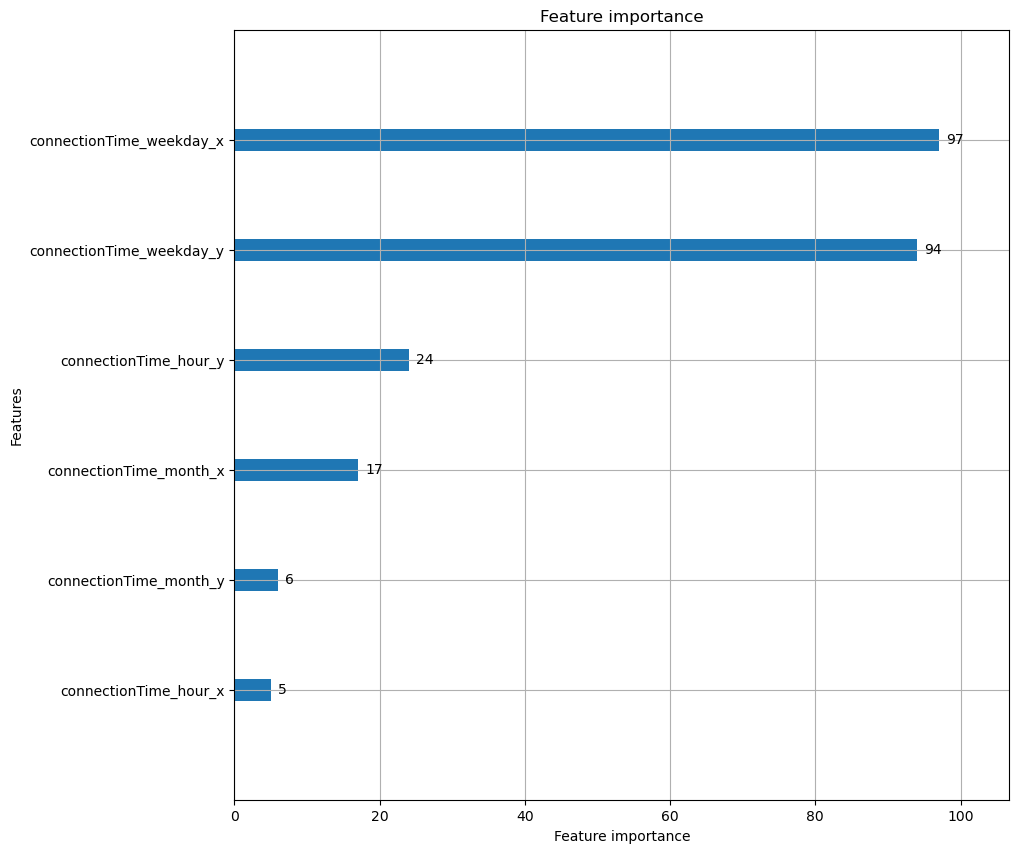

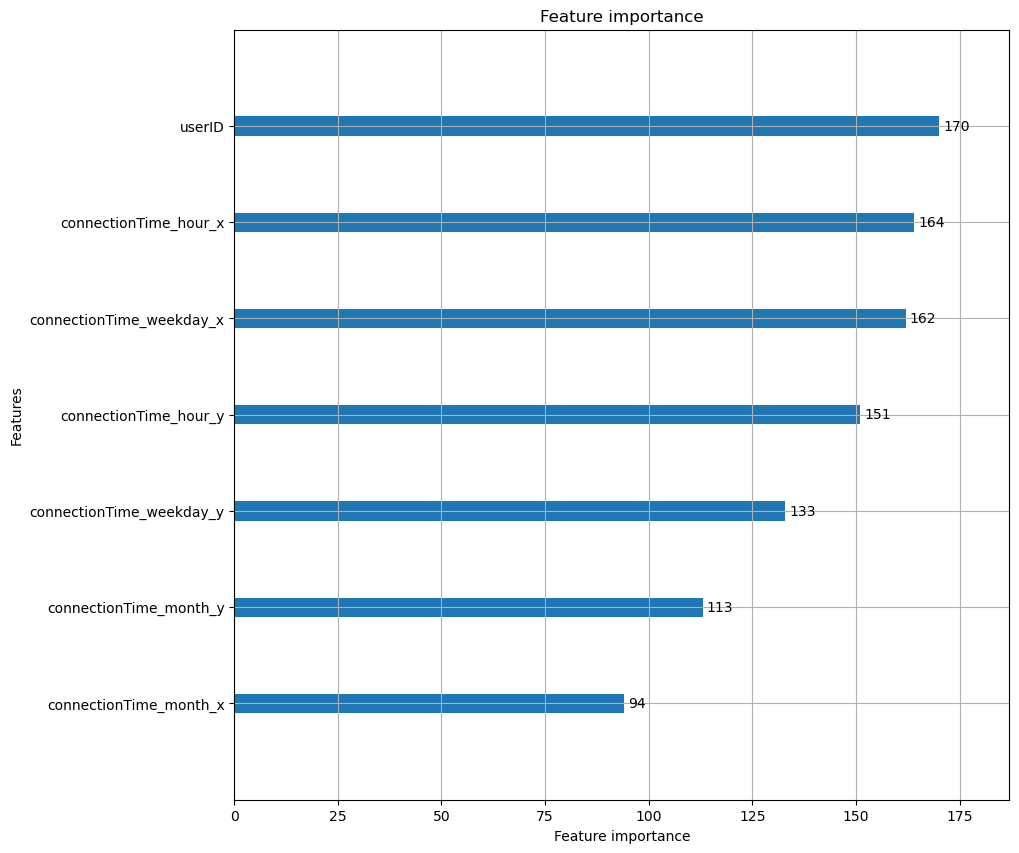

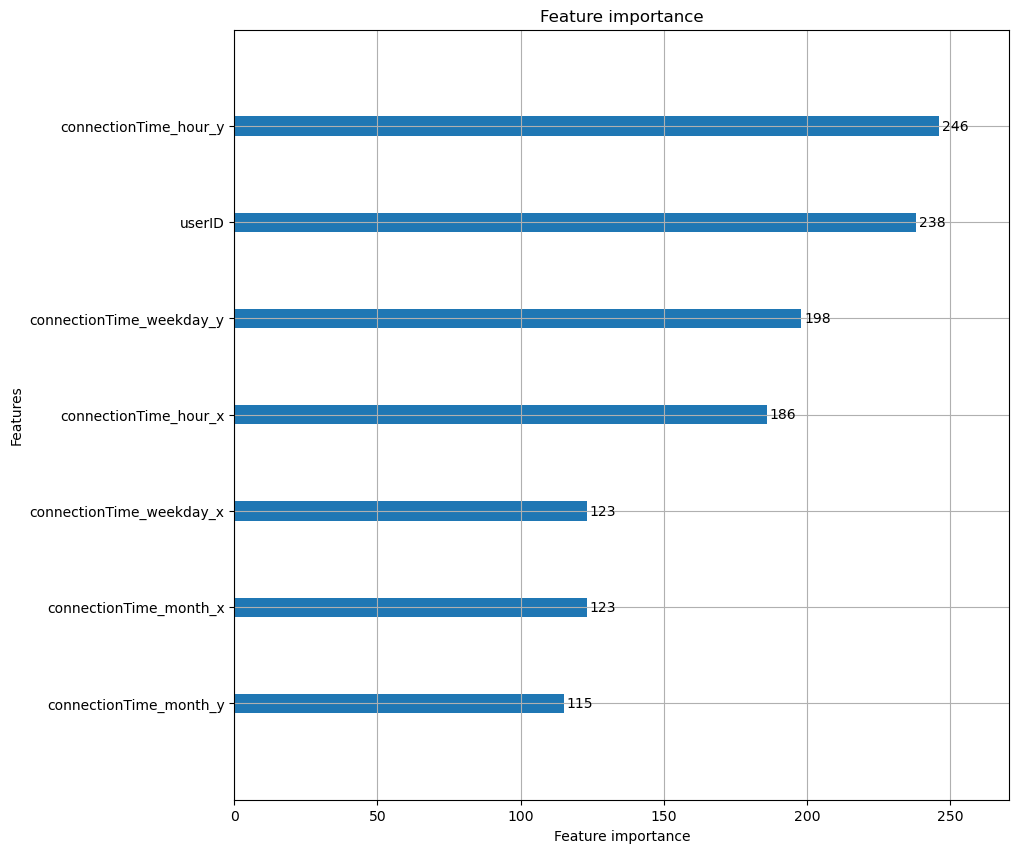

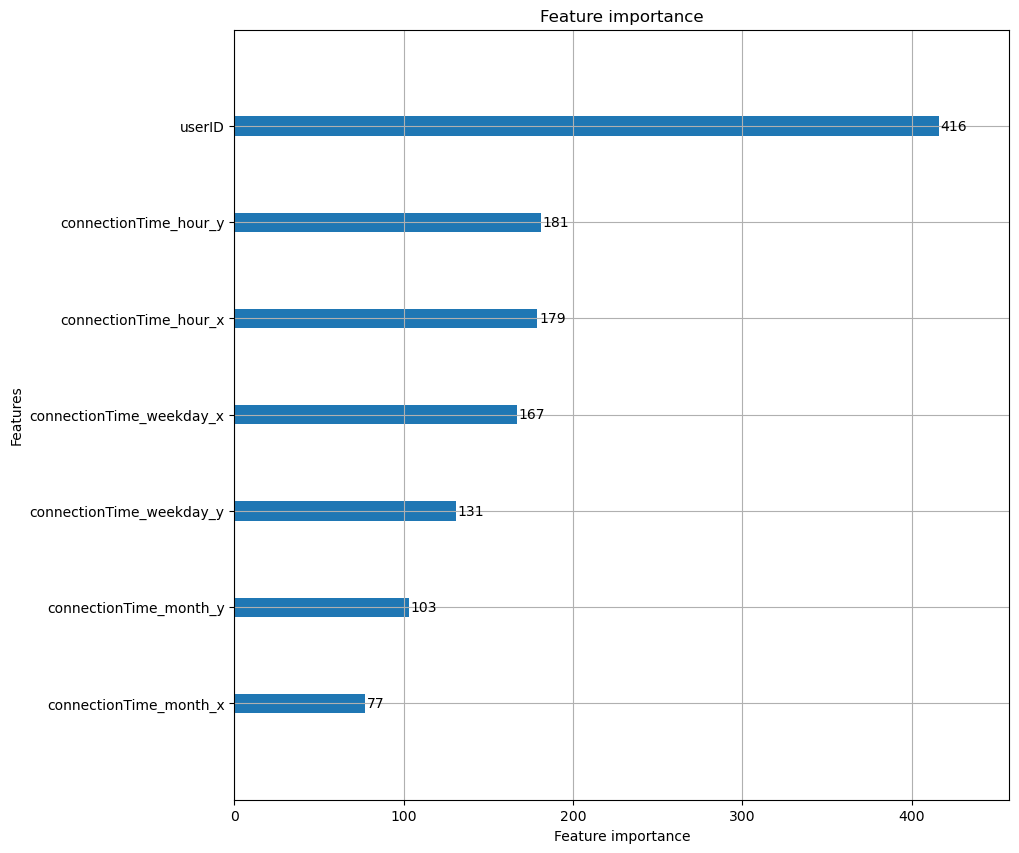

In [16]:
# feature importance of lightgbm model
def plot_feature_importance(model, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    lgb.plot_importance(model, ax=ax)
    plt.show()


# plot feature importance for each time interval
plot_feature_importance(model_0)
plot_feature_importance(model_1)
plot_feature_importance(model_2)
plot_feature_importance(model_3)
